<h2>Wikipedia Deep Learning with Word Embeddings</h2>
A problem with text classification using word occurrences or frequencies is the high-dimensional, sparse input vectors. A way of dealing with this is mapping the input vectors to lower dimensions using word embeddings. Here we use the word embedding layer in Keras.

<h3>Imports</h3>

In [1]:
import numpy as np
import pandas as pd
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Flatten, Dense, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
%matplotlib inline

print("TF version:", tf.__version__)

TF version: 2.2.0


<h3>Load data</h3>

In [2]:
# Load data
df = pd.read_csv("../data/wikipedia_300.csv")
np_data = df.values

# Split data into X and y
X_raw = np_data[:,0:-1]
y_raw = np_data[:,-1]

# Convert class label strings to integers
encoder = LabelEncoder()
encoder.fit(y_raw)
y = encoder.transform(y_raw)

# Flatten input matrix to vector
X_raw = X_raw.ravel()

print("Examples:",X_raw.shape[0])

Examples: 300


<h3>Pre-process data</h3>

In [3]:
# Tokenize the inputs: Each word is assigned a unique id and the input text is converted 
# to a list of word id integers
t = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False, oov_token=None, document_count=0)
t.fit_on_texts(X_raw)
X = t.texts_to_sequences(X_raw)

# Count number of unique words (vocabulary size)
vocab_size = len(t.word_counts) + 1
print("Vocabulary size: {}".format(vocab_size))

# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Check how many examples that are covered by padding sequences on the specified number of words limit
wmax = 0
maxlen = 5000
cnt_limit = 0
for i in range(0,len(X)):
    if len(X[i]) > wmax:
        wmax = len(X[i])
    if len(X[i]) > maxlen:
        cnt_limit += 1

print("Percentage of sequences covered by max length: {0:.2f}%".format(100 - cnt_limit / len(X) * 100))

# Pad input sequences to max length
x_train = pad_sequences(x_train, maxlen=maxlen, padding="post") 
x_test = pad_sequences(x_test, maxlen=maxlen, padding="post")

embedding_size = 100
print("Embeddings size:", embedding_size)

Vocabulary size: 51201
Percentage of sequences covered by max length: 77.33%
Embeddings size: 100


<h3>Function for training and evaluating a network</h3>

In [4]:
def train_and_evaluate(model, no_epochs=8):
    # Train model
    start = time.time()
    history = model.fit(x_train, y_train, epochs=no_epochs, verbose=0, batch_size=32, validation_split=0.2)
    end = time.time()
    print("Training time: {0:.2f} sec".format(end-start))
    
    # Plot training history
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

    # Evaluate model on test data
    score = model.evaluate(x_test, y_test, verbose=0)
    # Print results
    print("\nTest Accuracy: {0:0.2f}%".format(score[1] * 100))

<h3>Linear classifier</h3>

Training time: 6.42 sec


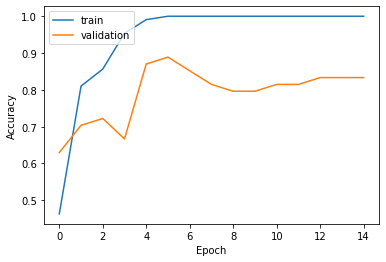


Test Accuracy: 93.33%


In [5]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

train_and_evaluate(model, no_epochs=15)

<h3>Neural Network classifier</h3>

Training time: 12.60 sec


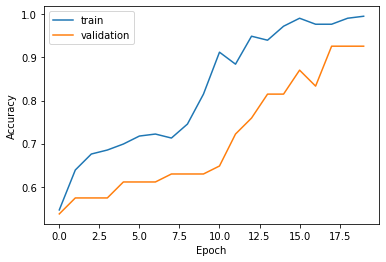


Test Accuracy: 96.67%


In [6]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=maxlen))
model.add(Flatten())
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

train_and_evaluate(model, no_epochs=20)

<h3>ConvNet classifier</h3>

Training time: 30.12 sec


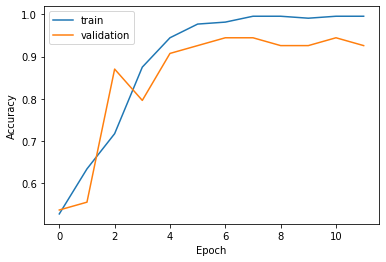


Test Accuracy: 100.00%


In [10]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=maxlen))
model.add(Conv1D(filters=64, kernel_size=8, padding="same", activation="relu"))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

train_and_evaluate(model, no_epochs=12)

<h3>Pre-trained GloVe word embeddings</h3>

See <a href="https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/">https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/</a> for more info.

You need to download and unzip the <em>glove.6b.zip</em> file from <a href="https://nlp.stanford.edu/projects/glove/">https://nlp.stanford.edu/projects/glove/</a>.

In [8]:
# Load the embedding into memory
embeddings_index = dict()
f = open("glove/glove.6B.100d.txt")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embeddings_index[word] = coefs
f.close()
print("Loaded {0} word vectors".format(len(embeddings_index)))

# Create a weight matrix for all words in the training set
mcnt = 0
tcnt = 0
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in t.word_index.items():
    tcnt += 1
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        mcnt += 1
print("{0} ({1:.2f}%) words missing in embedding".format(mcnt, mcnt/tcnt*100))

Loaded 400000 word vectors
18814 (36.75%) words missing in embedding


Training time: 23.41 sec


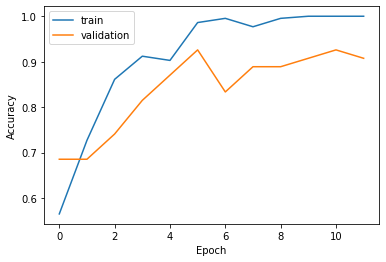


Test Accuracy: 93.33%


In [9]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen, weights=[embedding_matrix], trainable=False))
model.add(Conv1D(filters=64, kernel_size=8, padding="same", activation="relu"))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

train_and_evaluate(model, no_epochs=12)